In [14]:
%matplotlib inline
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

In [15]:
imdb_df = pd.read_csv('projectData.csv')
imdb_df = imdb_df.set_index('tconst')

imdb_df = imdb_df.drop('numVotes', axis=1)
imdb_df = imdb_df.drop('writers', axis=1)

In [16]:
genres_df = imdb_df['genres'].str.get_dummies(sep=',')
genres_df = genres_df.add_prefix('genre_')
imdb_df = pd.concat([imdb_df, genres_df], axis=1)
imdb_df = imdb_df.drop('genres', axis=1)


directors_df = imdb_df['directors'].str.get_dummies(sep=',')
directors_df = directors_df.add_prefix('dir_')
imdb_df = pd.concat([imdb_df, directors_df], axis=1)
imdb_df = imdb_df.drop('directors', axis=1)


actor_df = imdb_df['actor'].str.get_dummies(sep=',')
actor_df = actor_df.add_prefix('actor_')
imdb_df = pd.concat([imdb_df, actor_df], axis=1)
imdb_df = imdb_df.drop('actor', axis=1)

In [17]:
# define the bins
bins = [0, 2.4, 5.0, 7.4, 10]

# define the bin labels
labels = ['Terrible', 'Poor', 'Average', 'Excellent']

# create a new column with the bin labels
imdb_df['binRating'] = pd.cut(imdb_df['averageRating'], bins=bins, labels=labels, include_lowest=True)

imdb_df = imdb_df.drop('averageRating', axis=1)
imdb_df = pd.get_dummies(imdb_df, columns=['binRating'], prefix='bin')
imdb_df.head()

,runtimeMinutes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,actor_nm9500254,actor_nm9503133,actor_nm9576872,actor_nm9858131,actor_nm9862858,actor_nm9877392,bin_Terrible,bin_Poor,bin_Average,bin_Excellent
tconst,,,,,,,,,,,,,,,,,,,,,
tt0035423,118,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
tt0118589,104,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
tt0118694,98,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
tt0120202,105,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
tt0120630,84,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
X = imdb_df.drop(['bin_Average', 'bin_Excellent', 'bin_Poor', 'bin_Terrible'], axis=1)
y = imdb_df[['bin_Excellent']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=102)

In [46]:
# Train the Naive Bayes classifier
imdb_nb = MultinomialNB()
imdb_nb.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = imdb_nb.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8346415489272632


/Users/wileybattles/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
# predict probabilities
predProb_train = imdb_nb.predict_proba(X_train)
predProb_test = imdb_nb.predict_proba(X_test)

# predict class membership
y_test_pred = imdb_nb.predict(X_test)
y_train_pred = imdb_nb.predict(X_train)

In [48]:
classificationSummary(y_train, y_train_pred) 

classificationSummary(y_test, y_test_pred) 

Confusion Matrix (Accuracy 0.8311)

       Prediction
Actual    0    1
     0 2348    1
     1  483   34
Confusion Matrix (Accuracy 0.8346)

       Prediction
Actual    0    1
     0 1584    7
     1  309   11


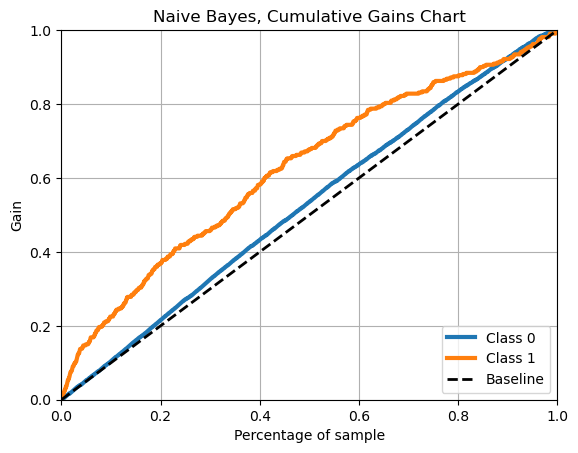

In [49]:
import scikitplot as skplt
from scikitplot.helpers import cumulative_gain_curve

skplt.metrics.plot_cumulative_gain(y_test, predProb_test)
plt.title('Naive Bayes, Cumulative Gains Chart')
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predict the labels for the testing set
imdb_nb_pred = imdb_nb.predict(X_test)

# Calculate the mean squared error (MSE) and root mean squared error (RMSE)
mse = mean_squared_error(y_test, imdb_nb_pred)
rmse = sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 0.16535845107273678
RMSE: 0.4066429036301221


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1591
           1       0.61      0.03      0.07       320

    accuracy                           0.83      1911
   macro avg       0.72      0.51      0.49      1911
weighted avg       0.80      0.83      0.77      1911

[[1584    7]
 [ 309   11]]
